In [12]:
import warnings
import numpy as np
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from dataset_tools import Dataset, lowpass_filter

In [2]:
warnings.filterwarnings("ignore")

# Loading & Extracting

In [5]:
number_of_datasets = 19
#initialising a list to store all the datasets
everyone = []

In [6]:
#runs through specified number of datasets and appends a Dataset abstraction to the list of everyone
for dataset_num in range(1,number_of_datasets+1):
    print(dataset_num, end=' ')
    dataset = Dataset(f'dataset/dataset_{dataset_num}.txt')
    everyone.append(dataset)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

Below is the format of the dataset

| 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10| 11| 12| 13| 14|15 | 16| 17|   18| 19| 20| 21| 22| 23| 24|
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
|Wrist:A1(X)|A2(Y)|A3(Z)|G1(x)|G2(Y)|G3(Z)|Chest:A1(X)|A2(Y)|A3(Z)|G1(X)|G2(Y)|G3(Z)|Hip:A1(X)|A2(Y)|A3(Z)|G1(X)|G2(Y)|G3(Z)|Ankle:A1(X)|A2(Y)|A3(Z)|G1(X)|G2(Y)|G3(Z)|Type|

# Visualising

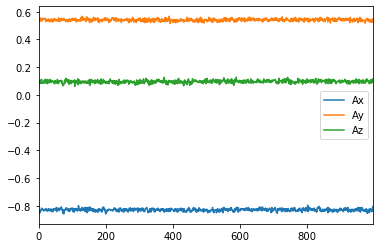

In [8]:
everyone[0].sitting['hip']['accel'][:1000].plot()

# Filtering

In [9]:
#Running through each dataset and filtering out the noise, also removes 300 rows of erroneous data from each activity
for idx, dataset in enumerate(everyone):
    print(idx, end=' ')
    lowpass_filter(dataset.data_frame, order=4, cutoff=5)
    dataset.extract_sensors(300)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 

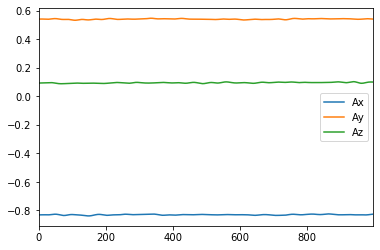

In [10]:
# Plotting the filtered data
everyone[0].sitting['hip']['accel'][:1000].plot()

# Feature Extraction

In [13]:
# window size is the number of rows that each feature is to extract on
window_size = 1000
features = [np.max, np.min, np.std, np.mean]

#instantiating the testing and training set
all_train, all_test = everyone[0].extract_all_features(features, window_size)

#Running through each dataset and creating a big training and testing dataset to store all the extract features
for idx, dataset in enumerate(everyone):
    print(idx, end=' ')
    if idx==0: continue
    d_train, d_test = dataset.extract_all_features(features, window_size)
    all_train = all_train.append(d_train)
    all_test = all_test.append(d_test)


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 

# Training & Testing Preprocessing

In [14]:
# Splitting the training and testing sets into respective activity and sensor dataframes, this is for the X and Y axes
training_sensors = all_train.loc[:,all_train.columns !='activity']
training_activities = all_train.loc[:,:'activity':-1]
testing_sensors = all_test.loc[:,all_test.columns !='activity']
testing_activities = all_test.loc[:,:'activity':-1]

In [15]:
# Scaling the testing and training set so that the data is being equally compared
scaler = preprocessing.StandardScaler().fit(training_sensors)
training_sensors = scaler.transform(training_sensors)
testing_sensors = scaler.transform(testing_sensors)

# KNN

In [17]:
#initialising the knn machine learning model
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(training_sensors, training_activities.values.ravel())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=4, p=2,
           weights='uniform')

In [18]:
# the actual knn prediction and confusion matrix
knn_prediction = knn.predict(testing_sensors)
knn_accuracy = accuracy_score(testing_activities, knn_prediction)
print('Accuracy: ', knn_accuracy)
print(confusion_matrix(testing_activities, knn_prediction))

Accuracy:  0.9430756159728122
[[ 43   1   0   0   0   0   0   0   0   0   0   0   0]
 [  0 105  12   0   0   0   0   0   0   0   0   0   0]
 [  0  26  90   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  37   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  57   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  38   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  58   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  54   0   0   0   0   3]
 [  0   0   0   0   0   0   0   0  83   0  14   0   1]
 [  0   0   0   0   0   0   0   0   0 115   0   0   0]
 [  0   0   0   0   0   0   0   0   3   0  55   0   0]
 [  1   0   0   0   0   0   0   0   0   0   5 258   0]
 [  0   0   0   0   0   0   0   0   0   0   1   0 117]]


# SVC

In [19]:
# The specific parameters for the kernel optimisation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-1,1e-2, 1e-3, 1e-4],
                     'C': [1e-3, 1e-2, 1e-1, 1, 10, 100, 100]},
                    {'kernel': ['linear'], 'C': [1e-3,1e-2, 1e-1, 1, 10, 100]}]
# Creating a scorer to test accuray of the model
acc_scorer = make_scorer(accuracy_score)
grid_obj  = GridSearchCV(SVC(), tuned_parameters, cv=10, scoring=acc_scorer)

In [20]:
# The actual svc fitting - WARNING: this takes about 10 minutes to run on my machine
grid_obj  = grid_obj.fit(training_sensors, training_activities.values.ravel())

In [21]:
# Fitting and predicting the SVC machine learning model
clf = grid_obj.best_estimator_
clf.fit(training_sensors, training_activities.values.ravel())
svc_prediction = clf.predict(testing_sensors)
svc_accuracy = accuracy_score(testing_activities, svc_prediction)
print('Accuracy: ', svc_accuracy)
print(confusion_matrix(testing_activities, svc_prediction))

Accuracy:  0.9668649107901445
[[ 43   0   0   0   0   0   0   0   1   0   0   0   0]
 [  0 112   5   0   0   0   0   0   0   0   0   0   0]
 [  0  12 104   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  36   0   0   0   0   1   0   0   0   0]
 [  0   0   0   0  57   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  38   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  58   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  57   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  92   0   6   0   0]
 [  0   0   0   0   0   0   0   0   0 115   0   0   0]
 [  0   0   0   0   0   0   0   0   6   0  52   0   0]
 [  1   0   0   0   0   0   0   0   1   0   4 258   0]
 [  0   0   0   0   0   0   0   1   0   0   1   0 116]]


# Comparison

### SVC

In [22]:
print('SVC Accuracy: ', svc_accuracy)
confusion_matrix(testing_activities, svc_prediction)

SVC Accuracy:  0.9668649107901445


array([[ 43,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0],
       [  0, 112,   5,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,  12, 104,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,  36,   0,   0,   0,   0,   1,   0,   0,   0,   0],
       [  0,   0,   0,   0,  57,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  38,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,  58,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  57,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  92,   0,   6,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0, 115,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   6,   0,  52,   0,   0],
       [  1,   0,   0,   0,   0,   0,   0,   0,   1,   0,   4, 258,   0],
       [  0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   1,   0, 116]])

### KNN

In [23]:
print('KNN Accuracy: ', knn_accuracy)
confusion_matrix(testing_activities, knn_prediction)

KNN Accuracy:  0.9430756159728122


array([[ 43,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 105,  12,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,  26,  90,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,  37,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,  57,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  38,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,  58,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  54,   0,   0,   0,   0,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,  83,   0,  14,   0,   1],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0, 115,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   3,   0,  55,   0,   0],
       [  1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   5, 258,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0, 117]])